In [1]:
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import seaborn as sns

from lightgbm_with_simple_features import (
    kfold_lightgbm,
    timer
)


In [2]:
data_path = 'C:/Users/Z478SG/Desktop/Ecole/OpenClassrooms-Projet-7/modeling/data/03_primary/df_agg.csv'
raw_data = pd.read_csv(data_path)

In [3]:
data = raw_data.copy()

In [4]:
# Fonction pour déterminer le type de données approprié
def determine_int_type(max_value):
    if max_value <= np.iinfo(np.int8).max:
        return np.int8
    elif max_value <= np.iinfo(np.int16).max:
        return np.int16
    elif max_value <= np.iinfo(np.int32).max:
        return np.int32
    else:
        return np.int64

# Parcourir chaque colonne et convertir le type de données si nécessaire
for col in data.select_dtypes(include=[np.int64]).columns:
    max_value = data[col].max()
    new_type = determine_int_type(max_value)
    data[col] = data[col].astype(new_type)

float64_cols = data.select_dtypes(include=[np.float64]).columns
data[float64_cols] = data[float64_cols].astype(np.float32)

In [5]:
data.dtypes.value_counts()

float32    606
bool       141
int8        49
int32        1
Name: count, dtype: int64

In [7]:
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(data, num_folds= 10, stratified= False, debug=False)

Starting LightGBM. Train shape: (307507, 797), test shape: (48744, 797)
[LightGBM] [Info] Number of positive: 22265, number of negative: 254491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 7.046448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92927
[LightGBM] [Info] Number of data points in the train set: 276756, number of used features: 773
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080450 -> initscore=-2.436250
[LightGBM] [Info] Start training from score -2.436250
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

KeyboardInterrupt: 

Certaines features ont beaucoup plus d'importance que d'autres. On va regarder la corrélation entre les variables qui ont une importance supérieure à 100. Ce seuil permet d'avoir un nombre de features raisonable pour notre modèle et est assez grand pour ne pas prendre des variables avec trop peu d'importance.

In [ ]:
filtered_features = feat_importance[["feature", "importance"]].groupby("feature").mean()
filtered_features = filtered_features[filtered_features["importance"] > 100]

# Sélectionner les noms des features
best_feats = filtered_features.index.tolist()
best_feats

NameError: name 'feat_importance' is not defined

In [50]:
correlation_matrix = data[best_feats].select_dtypes(exclude='object').corr()

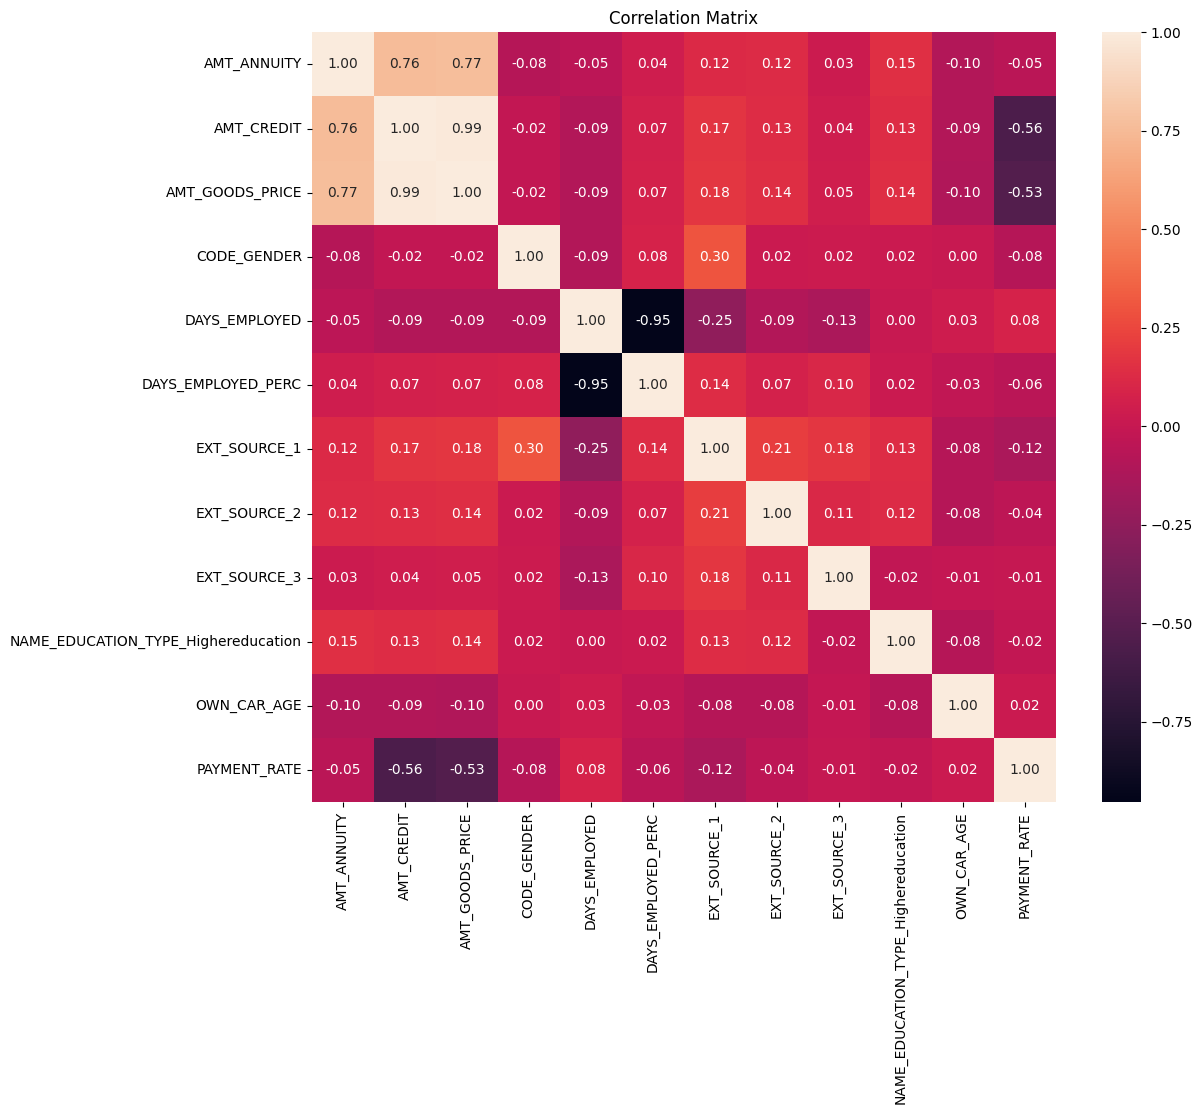

In [55]:
# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

On supprime DAYS_EMPLOYED_PERC car trop corrélé à une autre feature et moins importante.
On garde AMT_CREDIT et AMT_GOODS_PRICE car même si pas mal correlées à PAYMENT_RATE, elles sont assez importantes

In [ ]:
best_feats.remove('DAYS_EMPLOYED_PERC')
best_feats

['AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'CODE_GENDER',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'NAME_EDUCATION_TYPE_Highereducation',
 'OWN_CAR_AGE',
 'PAYMENT_RATE']

In [6]:
best_feats = ['AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'CODE_GENDER',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'NAME_EDUCATION_TYPE_Highereducation',
 'OWN_CAR_AGE',
 'PAYMENT_RATE']

In [7]:
train_df = data[data['TARGET'].notnull()]

X = train_df[best_feats]
y = train_df["TARGET"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

In [8]:
# LightGBM classifier
model = LGBMClassifier(
    nthread=4,
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=34,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.041545473,
    reg_lambda=0.0735294,
    min_split_gain=0.0222415,
    min_child_weight=39.3259775,
    random_state=18,
    )

# Entraîner le modèle sur l'ensemble d'entraînement complet
model.fit(X_train, y_train)

# Prédire les probabilités sur l'ensemble de test
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculer l'AUC-ROC sur l'ensemble de test
test_auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC-ROC: {test_auc_roc}")

[LightGBM] [Info] Number of positive: 19945, number of negative: 226060
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2093
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081076 -> initscore=-2.427822
[LightGBM] [Info] Start training from score -2.427822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

C:\Users\Z478SG\AppData\Roaming\Python\Python312\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


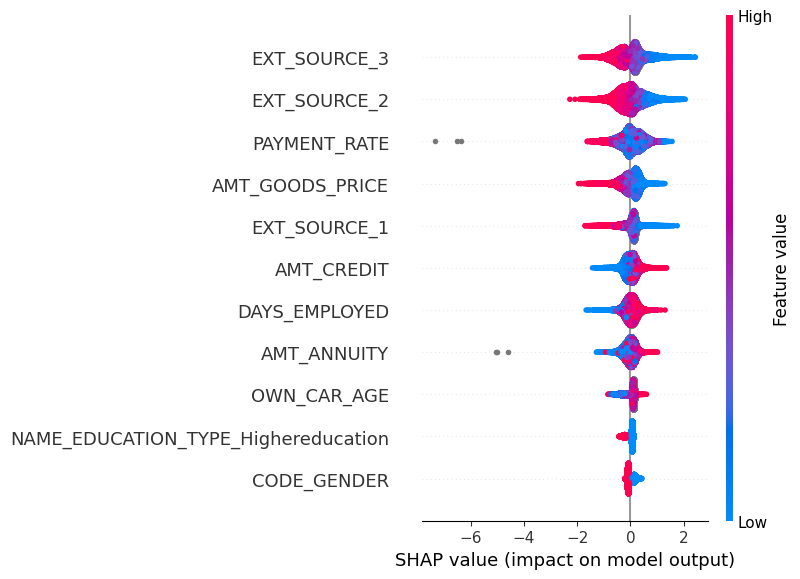

In [10]:
import shap
import os

def analyze_feature_importance(model, X):
    feat_imp_path = os.path.join(os.getcwd(), '..', 'data', '08_reporting')

    # Importance globale des features
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    # Résumé de l'importance globale
    shap.summary_plot(shap_values, X)
    plt.savefig(os.path.join(feat_imp_path, 'global_feat_imp_plot.png'))  # Save the summary plot
    plt.close()  # Close the plot to free up memory

    # Importance locale pour un exemple spécifique
    shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])
    plt.savefig(os.path.join(feat_imp_path, 'local_feat_imp_plot.png'))  # Save the force plot
    plt.close()  # Close the plot to free up memory

# Utilisation
analyze_feature_importance(model, X_test)

Le graphique SHAP du modèle LGBMClassifier révèle l'importance des différentes caractéristiques utilisées pour prédire le score d'accord de prêt bancaire. Les caractéristiques les plus influentes sont les sources externes (EXT_SOURCE_3, EXT_SOURCE_2, EXT_SOURCE_1) et le taux de paiement (PAYMENT_RATE). Des valeurs élevées de ces caractéristiques augmentent la probabilité d'accorder le prêt, tandis que des valeurs faibles la diminuent. Le prix des biens (AMT_GOODS_PRICE) et le montant de l'annuité (AMT_ANNUITY) ont également un impact notable, mais inversé : des valeurs élevées tendent à réduire la probabilité d'accord du prêt.

D'autres caractéristiques comme le nombre de jours employés (DAYS_EMPLOYED), le niveau d'éducation (NAME_EDUCATION_TYPE_Highereducation), l'âge de la voiture possédée (OWN_CAR_AGE), le genre (CODE_GENDER), et le montant du crédit (AMT_CREDIT) montrent des impacts variés mais généralement modérés.

En résumé, pour améliorer la précision du modèle et la prise de décision concernant l'accord de prêts, il est crucial de surveiller et d'analyser en profondeur les sources externes et les caractéristiques liées aux paiements et aux biens. Ces éléments jouent un rôle clé dans la prédiction du score et peuvent significativement influencer la décision finale de la banque.